In [52]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

In [61]:
words = open(r"C:\Users\banda\Downloads\names.txt", 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [63]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


## dataset building

In [64]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [65]:
Xtr.shape, Xtr.dtype, Ytr.shape, Ytr.dtype

(torch.Size([182625, 3]), torch.int64, torch.Size([182625]), torch.int64)

In [240]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # random number generator. seed is used to generate same random numbers generated every time we run the program.

# Initialize the embedding matrix 'C' with random values.
# 'C' has a shape of (vocab_size, n_embd) where each row corresponds to a character's embedding.
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01

# you should not set weight of a neuralnets to zero, we usually set to small numbers instead of exactly zero.
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))


parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # totalnumber of parameters
for p in parameters:
  p.requires_grad = True

12097


In [241]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # normalize
    hpreact = embcat @ W1  # + b1 # hidden layer pre-activation

    # batch norm layer
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    # non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
  

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


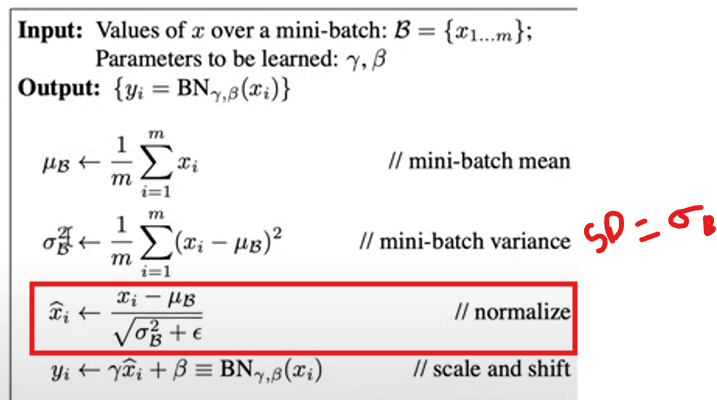

#### 1. reduce initial loss(27.8817)
   - this is issue is due to initialization. what is happening is at initalization the neuralnet is creating probability distribution that all are messed up. Some characters are very confident and some characters are very not confident. So, in conclusion network is very confidently wrong, this is why it is recording very high loss. refer below example:

In [127]:
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([2.3168e-02, 4.6081e-08, 9.7674e-01, 8.9643e-05]), tensor(0.0235))

   - at initialization we have no reason to believe any character to be much more likely than others. so we expect that the probality distribution that comes out initially is a uniform distribution assigning about equal probability to all the 27 chars.
   - basically what we like is probability for any character would be roughly 1 over 27.

---
## before optimization
    before multiplying rthe W1, b1 with 0.1 and 0.01

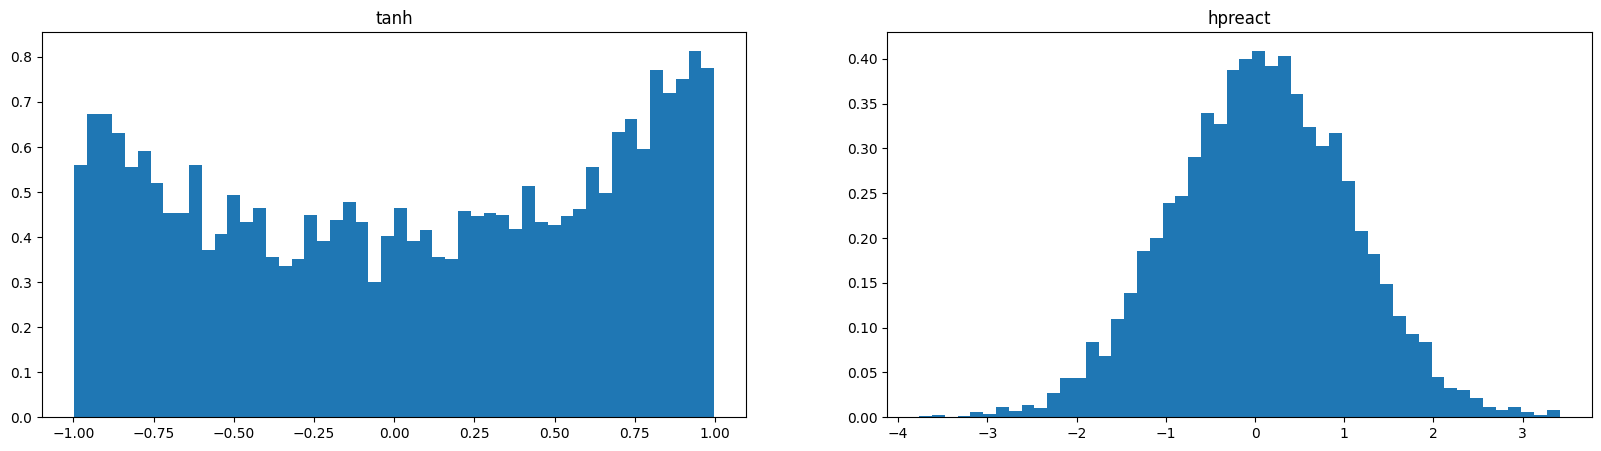

In [199]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.title("tanh")
plt.hist(h.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.title("hpreact")
plt.hist(hpreact.view(-1).tolist(), 50, density=True);

### Why is this "not good"?
1. **Pre-activations (`hpreact`) are too large** (ranging from -20 to 20):
   - When pre-activation values are large, the `tanh` function saturates (i.e., outputs values near -1 or 1).
   - In saturation regions, the gradient of `tanh` (which is \( 1 - \tanh^2(x) \)) becomes **near-zero**. This causes **vanishing gradients** during backpropagation, halting learning in affected neurons.

2. **Activations (`h`) are mostly near extremes** (peaks near -1 and 1):
   - If most activations are saturated, the network cannot propagate meaningful gradient signals backward. This makes training slow, unstable, or even impossible.

---

### Key Point:
A network with **saturated activations** (due to poor initialization or improper scaling) is "not good" because:
- **Vanishing gradients**: No useful gradient signal for weight updates.
- **Dead neurons**: Neurons stuck in saturation stop learning entirely.
- **Poor optimization**: The loss landscape becomes flat in saturated regions, making it hard for gradient descent to make progress.

---

### Solution:
1. **Proper initialization**: Use methods like Xavier/Glorot initialization, which scales weights based on the number of input/output neurons to keep pre-activations in a reasonable range (e.g., [-1, 1]).
2. **Activation scaling**: Normalize inputs or use activation functions like `tanh` with care (or alternatives like `ReLU` with careful initialization).
3. **Batch Normalization**: Forces activations to have zero mean and unit variance, preventing saturation.

The goal is to ensure pre-activations stay in the **linear regime** of the activation function (e.g., near 0 for `tanh`), where gradients are strong and learning can occur efficiently.

## After optimization

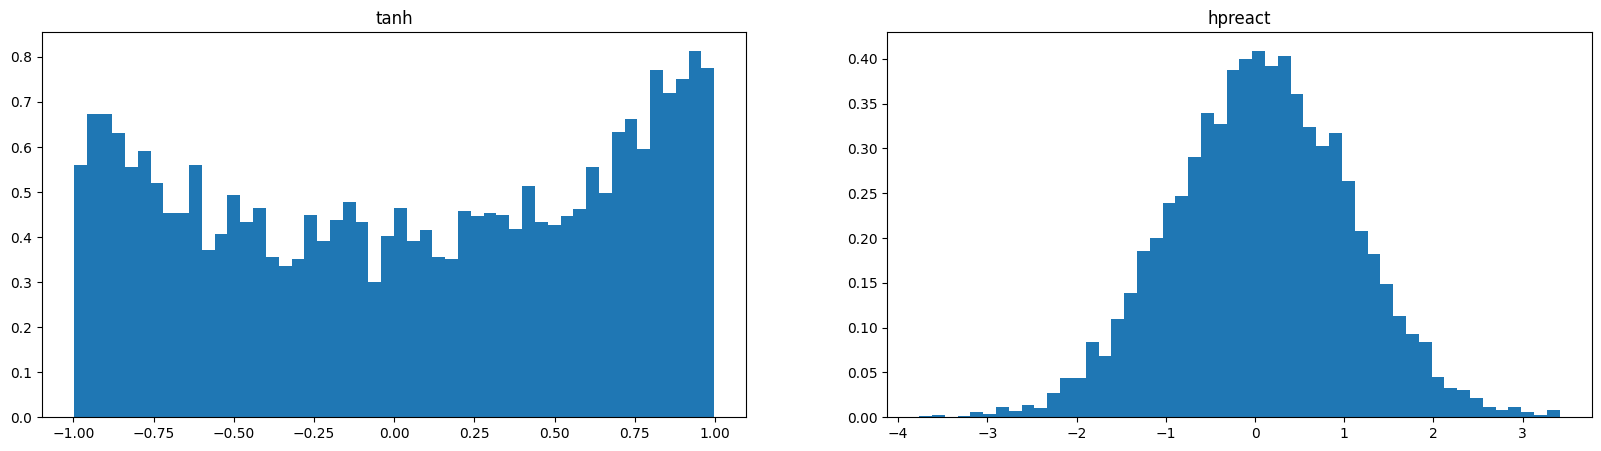

In [197]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.title("tanh")
plt.hist(h.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.title("hpreact")
plt.hist(hpreact.view(-1).tolist(), 50, density=True);

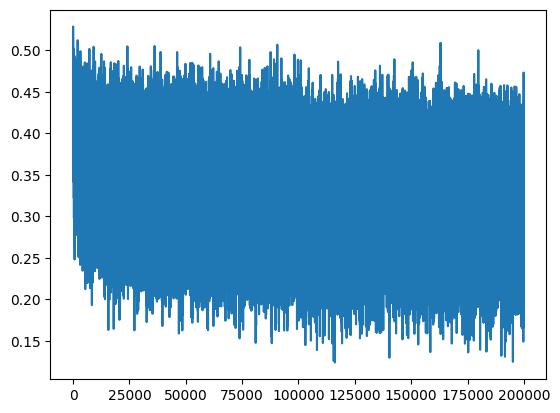

In [242]:
plt.plot(lossi);

In [231]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [243]:
@torch.no_grad() # disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concate into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)

    logits = h @ W2 + b2 # (n, vocal_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.066636800765991
val 2.105013132095337


In [250]:
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch .tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out))

briangmyazziyes.
bdulyah.
briyas.
brdrner.
sherkodrlithlyllsenleigh.
santhannchyziohmkrrnn.
shdumrishimnest.
jadestly.
prgbdulfuubdgghder.
jaquezmashburjahsis.
dashby.
sadya.
sus.
zakquslutel.
subristia.
sumprrdnn.
quloeonandphillsamreyxa.
hunton.
bdasirfalvinnwrllwildtalfr.
tandysestss.
